# ECMWF DATA

In [1]:
%matplotlib notebook

In [2]:
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.
nm2km=1.852


The ecmwf data regarding track info are given as bufr files. The can be accessed using the routine read_bufr (see in StormS dropbox folder) 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import griddata
import pandas

In [4]:
from readbufr import read_bufr

In [9]:
hurName='ROANU'

In [10]:
trackName=''.join([x for x in hurName if not (x.isdigit() or x == '-')])
trackName

'ROANU'

In [11]:
tc=read_bufr(trackName)

we can see the available data stored in the dictionary 

In [12]:
print tc.keys()

['201605200000', '201605191200', '201605211200', '201605210000', '201605201200']


the above timestamps have the available info

In [13]:
tc[tc.keys()[0]].keys()

['ulats', 'center', 'plons', 'maxv', 'p', 'ulons', 't', 'plats']

So e.g we can plot the track according to ECMWF as 

<IPython.core.display.Javascript object>


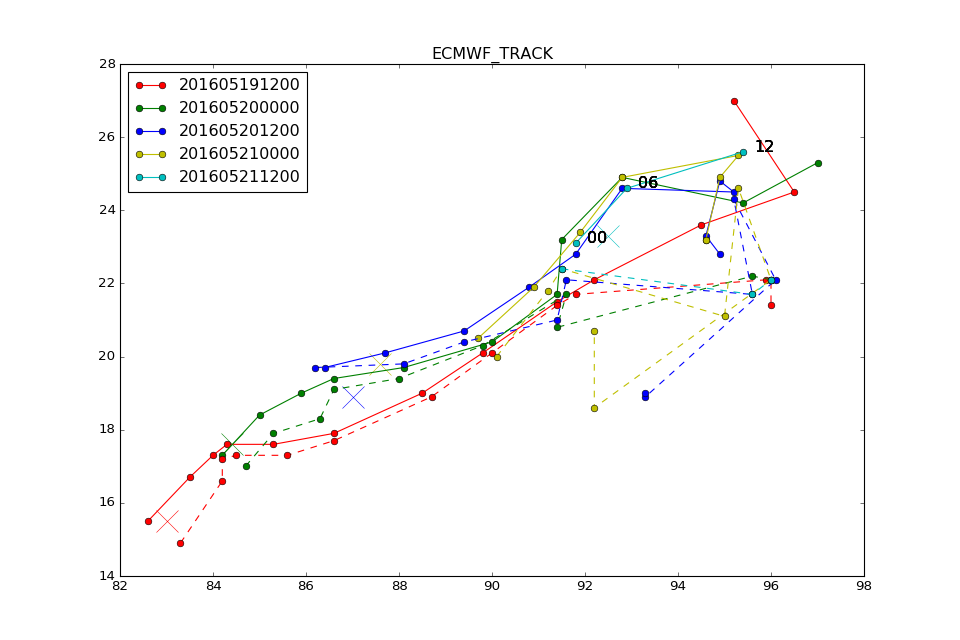

/usr/lib/python2.7/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [14]:

plt.figure(figsize=(12,8))
plt.gca().set_color_cycle(['r','g','b','y','c'])

for key in sorted(tc.keys()):
        plt.plot(tc[key].center[0],tc[key].center[1],'x',markersize=20)#,label=key)

plt.gca().set_color_cycle(['r','g','b','y','c'])

for key in sorted(tc.keys()):  
    datp = zip(tc[key].plons,tc[key].plats,tc[key].t)

    if np.max(datp) > 400. :
       datmp=np.ma.masked_array(datp,datp==np.max(dat))
    else:
       datmp=np.array(datp)

    plt.plot(datmp[:,0],datmp[:,1],'o-',label=key)

plt.gca().set_color_cycle(['r','g','b','y','c'])
   
for key in sorted(tc.keys()):
    datu = zip(tc[key].ulons,tc[key].ulats,tc[key].t)

    if np.max(datu) > 400. :
       datmu=np.ma.masked_array(datu,datu==np.max(dat))
    else:
       datmu=np.array(datu)

    plt.plot(datmu[:,0],datmu[:,1],'o--')#,label=key)

    for x,y,t in datp:
      if x:
        plt.annotate('%02i' %(t),xy=(x,y), xytext=(10,0), textcoords='offset points', size='large',color='k')
plt.title('ECMWF_TRACK')
plt.legend(loc=0)
plt.show()

Observe that there are 2 tracks (minimum pressure and maximum velocity). The poligons give the center of the TC (which in theory should by the location of minimum pressure)

for the u,v,p data we need to parse the netcdf files and also interpolate on a spiderweb grid around the center of the TC

In [11]:
stamp=sorted(tc.keys())[2]
stamp

'201605201200'

In [12]:
info=tc[stamp]
info

Bunch(center=[87.0, 18.899999999999999], maxv=array([ 20.6,  22.6,  24.7,  24.2,  18.5,  10.3,   9.8,   8.8,   8.2,  10.8]), p=array([  98600.,   98600.,   98300.,   98400.,   98300.,   99400.,
         99500.,   99800.,   99800.,  100200.]), plats=array([ 19.7,  20.1,  20.7,  21.9,  22.8,  24.6,  24.5,  24.8,  23.3,  22.8]), plons=array([ 86.4,  87.7,  89.4,  90.8,  91.8,  92.8,  95.2,  94.9,  94.6,  94.9]), t=array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.]), ulats=array([ 19.7,  19.8,  20.4,  21. ,  22.1,  21.7,  24.3,  22.1,  18.9,  19. ]), ulons=array([ 86.2,  88.1,  89.4,  91.4,  91.6,  95.6,  95.2,  96.1,  93.3,  93.3]))

### compute TC traslational velocity from forecast

First compute dlat/dt

In [13]:
z2=np.polyfit(info.t,info.plats,2)
f2=np.poly1d(z2)
z3=np.polyfit(info.t,info.plats,3)
f3=np.poly1d(z3)
z4=np.polyfit(info.t,info.plats,4)
f4=np.poly1d(z4)
z5=np.polyfit(info.t,info.plats,5)
f5=np.poly1d(z5)

In [14]:
plt.figure(figsize=(12,8))
for i in range(info.plons.size):
   plt.plot(info.t,info.plats,'bo')

x_new=np.linspace(info.t[0],info.t[-1],50)
plt.plot(x_new,f2(x_new),'k--',label='2nd order')
plt.plot(x_new,f3(x_new),'r-',label='3nd order')
plt.plot(x_new,f4(x_new),'gx',label='4nd order')
plt.plot(x_new,f5(x_new),'y+',label='5nd order')


plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>

In [15]:
q1=f5.deriv() #dlat/dt

.. now dlon/dt

In [16]:
z2=np.polyfit(info.t,info.plons,2)
f2=np.poly1d(z2)
z3=np.polyfit(info.t,info.plons,3)
f3=np.poly1d(z3)
z4=np.polyfit(info.t,info.plons,4)
f4=np.poly1d(z4)
z5=np.polyfit(info.t,info.plons,5)
f5=np.poly1d(z5)

In [17]:
plt.figure(figsize=(12,8))
for i in range(info.plons.size):
   plt.plot(info.t,info.plons,'bo')

x_new=np.linspace(info.t[0],info.t[-1],50)
plt.plot(x_new,f2(x_new),'k--',label='2nd order')
plt.plot(x_new,f3(x_new),'r-',label='3nd order')
plt.plot(x_new,f4(x_new),'gx',label='4nd order')
plt.plot(x_new,f5(x_new),'y+',label='5nd order')


plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>

In [18]:
q2=f5.deriv() #dlon/dt

In [19]:
# compute ds/dt

In [20]:
z2=np.polyfit(info.plons,info.plats,2)
f2=np.poly1d(z2)
z3=np.polyfit(info.plons,info.plats,3)
f3=np.poly1d(z3)
z4=np.polyfit(info.plons,info.plats,4)
f4=np.poly1d(z4)
z5=np.polyfit(info.plons,info.plats,5)
f5=np.poly1d(z5)

In [21]:
plt.figure(figsize=(12,8))
for i in range(info.plons.size):
   plt.plot(info.plons,info.plats,'bo')

x_new=np.linspace(info.plons[0],info.plons[-1],50)
plt.plot(x_new,f2(x_new),'k--',label='2nd order')
plt.plot(x_new,f3(x_new),'r-',label='3nd order')
plt.plot(x_new,f4(x_new),'gx',label='4nd order')
plt.plot(x_new,f5(x_new),'y+',label='5nd order')


plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>

In [22]:
qs=f5.deriv() #dlon/dlat

In [23]:
cincl=q1(info.t)/qs(info.t)
print cincl

[  8.06118931e-08   5.43034747e-08   1.49920518e-07   3.29847231e-07
   5.06484837e-07   5.13819874e-07   9.03773412e-08  -1.02729920e-06
  -2.44585307e-06   2.19412936e-07]


In [24]:
sincl=q2(info.t)/qs(info.t)
print sincl

[  2.55092944e-07   1.82250104e-07   2.26747283e-07   3.71964298e-07
   5.67967973e-07   7.10809304e-07   6.28327689e-07   1.40917533e-07
  -4.82604095e-07   1.82884533e-06]


In [25]:
vt=qs(info.t)/3600. # to sec
print vt

[ 427.0999573   324.80473233  242.08200004  176.26096456  124.86674877
   85.62039436   56.4388618    35.43503035   20.91769808   11.39158182]


In [26]:
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180

In [27]:
vtrx0 = vt * cincl * deg2m
vtrx = vtrx0 *np.cos(np.radians(info.plats)) #compute translational vx=vt*cos(phi) adjusted for latitude
vtry = vt * sincl * deg2m


In [28]:
vtr = np.sqrt(vtrx**2+vtry**2)

pandas.DataFrame(np.array([vtrx,vtry,vtr]).T,columns=['x-vel','y-vel','total'])

,x-vel,y-vel,total
0,3.608475,12.128756,12.654162
1,1.843943,6.589894,6.843013
2,3.779459,6.110727,7.185075
3,6.005216,7.298703,9.451650
4,6.490348,7.895124,10.220450
5,4.453004,6.775146,8.107518
6,0.516713,3.947778,3.981450
7,-3.678726,0.555887,3.720489
8,-5.231020,-1.123811,5.350376
9,0.256508,2.319259,2.333401


### Read u,v,p

In [29]:
PATH='/mnt/ECMWF/grib/'

In [30]:
date=datetime.datetime.strptime(stamp,'%Y%m%d%H%S')
date

datetime.datetime(2016, 5, 20, 12, 0)

In [31]:
infile=PATH+'{}/{:02d}/{:02d}/{}.tropical_cyclone.grib'.format(date.year,date.month,date.day,datetime.datetime.strftime(date,'%Y%m%d.%H'))

In [32]:
time=0

In [33]:
from gribapi import *

f=open(infile)

dat={} # create a dictionary 
    
for l in range(3): # loop for the first 3 messages
    gid=grib_new_from_file(f)
    if gid is None: break

    name=grib_get(gid, 'shortName')
    print name
    dat[name]=grib_get_values(gid)
    dat['latitudes']=grib_get_array(gid,'latitudes')
    dat['longitudes']=grib_get_array(gid,'longitudes')
    
    grib_release(gid)
    
f.close()

msl
10u
10v


In [34]:
dat

{'10u': array([-5.48501587, -5.48208618, -5.47915649, ..., -0.45083618,
        -0.44790649, -0.44497681]),
 '10v': array([ 1.99453735,  2.00137329,  2.00820923, ..., -2.63632202,
        -2.63729858, -2.63827515]),
 'latitudes': array([ 89.94618772,  89.94618772,  89.94618772, ..., -89.94618772,
        -89.94618772, -89.94618772]),
 'longitudes': array([  0.00000000e+00,   7.03125610e-02,   1.40625122e-01, ...,
          3.59789375e+02,   3.59859687e+02,   3.59930000e+02]),
 'msl': array([ 101019.0625,  101019.0625,  101019.0625, ...,  101677.3125,
         101677.0625,  101677.0625])}

In [35]:
u=dat['10u'].reshape((2560, 5120))
v=dat['10v'].reshape((2560, 5120))
msl=dat['msl'].reshape((2560, 5120))
lats=dat['latitudes'].reshape((2560, 5120))
lons=dat['longitudes'].reshape((2560, 5120))
latitudes=lats[:,0]
longitudes=lons[0,:]

In [36]:
latitudes

array([ 89.94618772,  89.87647835,  89.80635732, ..., -89.80635732,
       -89.87647835, -89.94618772])

In [37]:
lon0, lat0= info.center[0], info.center[1]

In [38]:
#LAN/LON WINDOW
minlon=lon0-5.
maxlon=lon0+5.
minlat=lat0-5.
maxlat=lat0+5.

In [39]:
lath=((latitudes>minlat)&(latitudes<maxlat)).nonzero()[0] # get the lat window to match our data above
lmin=minlon
lmax=maxlon
if lmin < 0 : lmin=lmin+360.
if lmax < 0 : lmax=lmax+360.

lonh=((longitudes>lmin)&(longitudes<lmax)).nonzero()[0] # same as above for lon


In [40]:
uu=u[lath[0]:lath[-1]+1,lonh[0]:lonh[-1]+1]   # select the velocity window
vv=v[lath[0]:lath[-1]+1,lonh[0]:lonh[-1]+1]
slpw=msl[lath[0]:lath[-1]+1,lonh[0]:lonh[-1]+1]
utot=np.sqrt(uu**2+vv**2)  # total velocity


In [41]:
lonw=longitudes[lonh]
latw=latitudes[lath]
[[lmp1,lmp2]]=np.argwhere(slpw==slpw.min())  # location of minimum pressure

In [42]:
lx,ly=np.meshgrid(lonw,latw)

In [43]:
plt.figure(figsize=(12,8))
C1=plt.contourf(lonw,latw,slpw,30)
plt.quiver(lx,ly,uu,vv)
plt.plot(lon0,lat0,'ro', label='TC center from bufr')
plt.plot(lx[lmp1,lmp2],ly[lmp1,lmp2],'gx', markersize=20, label='ECMWF minimum pressure')
plt.legend()
plt.colorbar(C1,label='PA')
plt.title('Original')
plt.show()

<IPython.core.display.Javascript object>

In [44]:
# translate to stationary frame by substracting the translational velocity of the TC
us=uu-vtrx[0]
vs=vv-vtry[0]
ust=np.sqrt(us**2+vs**2)


<IPython.core.display.Javascript object>


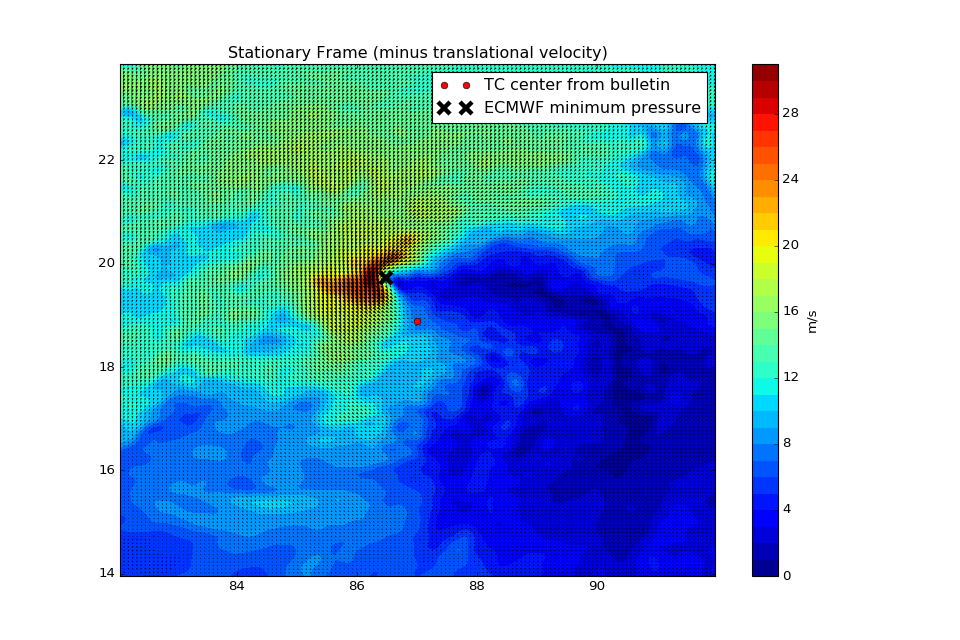

In [46]:
plt.figure(figsize=(12,8))
plt.quiver(lx,ly,us,vs)
lonp=lon0
if lonp < 0. : lonp = lonp + 360.
plt.plot(lonp,lat0,'ro', label='TC center from bulletin')
plt.plot(lx[lmp1,lmp2],ly[lmp1,lmp2],'x', markersize=10,markeredgecolor='k', markerfacecolor='w', mew=4, label='ECMWF minimum pressure')
C2=plt.contourf(lonw,latw,ust,30)
plt.colorbar(C2, label='m/s')
plt.quiver(lx,ly,us,vs)

plt.legend()
plt.title('Stationary Frame (minus translational velocity)')
plt.show()


In [47]:
from math import radians, cos, sin, asin, sqrt
def Haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6378.388 * c
    return  km



In [48]:
latc0=ly[lmp1,lmp2]
lonc0=lx[lmp1,lmp2]

In [49]:
# compute radius from ECMWF's TC center for (lat,lon) cross sections
rx=np.zeros(lonw.shape)
ry=np.zeros(latw.shape)
for i in range(lonw.size):
    rx[i]=Haversine(lonw[i],latc0, lx[lmp1,lmp2], ly[lmp1,lmp2])#*1000. # the holland function wants distance in m.
    if lonw[i] < lonc0 : rx[i] = -rx[i]
for j in range(latw.size):
    ry[j]=Haversine(lonc0,latw[j], lx[lmp1,lmp2], ly[lmp1,lmp2])#*1000. # the holland function wants distance in m.
    if latw[j] < latc0 : ry[j] = -ry[j]


In [60]:
print np.array(zip(rx,ust[lmp1,:]))

[[-464.19998645   13.0467618 ]
 [-456.83214105   12.94448049]
 [-449.46427604   12.60634135]
 [-442.09639173   11.98946745]
 [-434.72848843   11.4891102 ]
 [-427.36056648   11.14387486]
 [-419.99262619   10.93203966]
 [-412.62466786   10.55041353]
 [-405.25669183   10.02723442]
 [-397.8886984     9.73573732]
 [-390.5206879     9.71917616]
 [-383.15266063    9.81873316]
 [-375.78461693    9.93945736]
 [-368.4165571    10.07304093]
 [-361.04848146   10.44146953]
 [-353.68039033   11.15626247]
 [-346.31228403   12.1729001 ]
 [-338.94416287   12.5646938 ]
 [-331.57602717   12.69959607]
 [-324.20787724   12.82199043]
 [-316.8397134    13.13830684]
 [-309.47153598   13.5046166 ]
 [-302.10334528   13.86587939]
 [-294.73514162   14.05698422]
 [-287.36692532   14.13203416]
 [-279.99869669   14.34129087]
 [-272.63045605   14.64308829]
 [-265.26220373   14.83236466]
 [-257.89394002   14.71311389]
 [-250.52566526   14.15464016]
 [-243.15737976   13.10723855]
 [-235.78908382   12.34911921]
 [-228.4

In [50]:
# radial grid
th=np.linspace(0,2*np.pi,37)
rr=np.linspace(0.,3.,201) 
rad, the = np.meshgrid(rr,th)

In [51]:
rlon = rad * np.cos(the)
rlat = rad * np.sin(the)

<IPython.core.display.Javascript object>


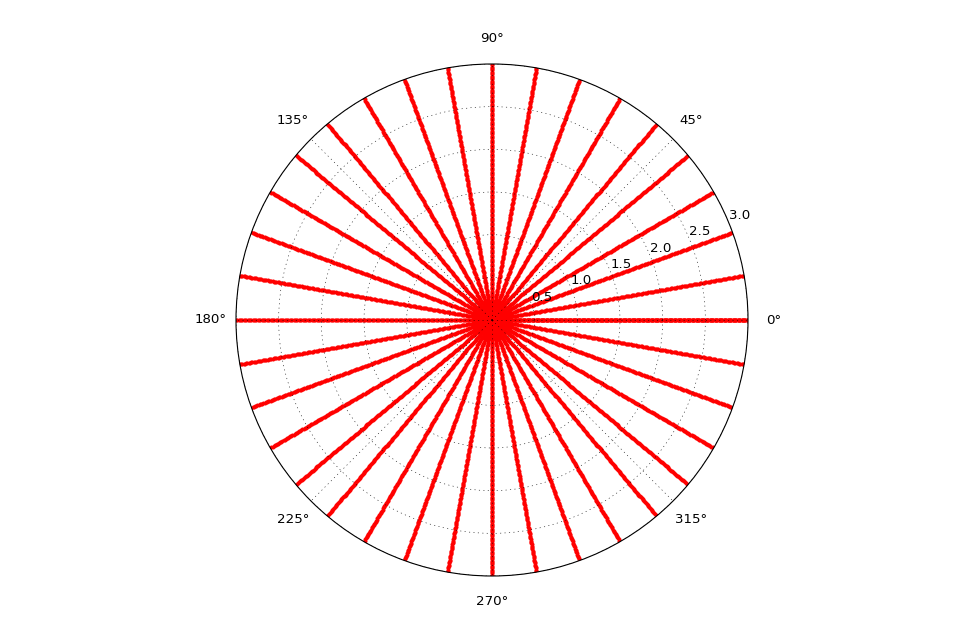

In [52]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, polar=True)
ax.plot(the, rad, color='r', ls='none', marker='.')
plt.show()

In [53]:
### WE TRANSLATE THE RADIAL GRID TO THE ECMWF CENTER

nlon=rlon+lx[lmp1,lmp2]
nlat=rlat+ly[lmp1,lmp2]

## INTERPOLATE
ui = griddata((lx.ravel(),ly.ravel()), ust.ravel(), (nlon,nlat), method='cubic')

uec=ui.reshape(37,201) # reshape to original (theta,rad) array
[[o1,o2]]=np.argwhere(uec==uec[np.isfinite(uec)].max())

# translate to km
rec=[]
for x,y in zip(nlon.ravel(),nlat.ravel()):
  rec.append(Haversine(x,y, lx[lmp1,lmp2],ly[lmp1,lmp2]))

rec=np.array(rec)
rec=rec.reshape(37,201)

<IPython.core.display.Javascript object>


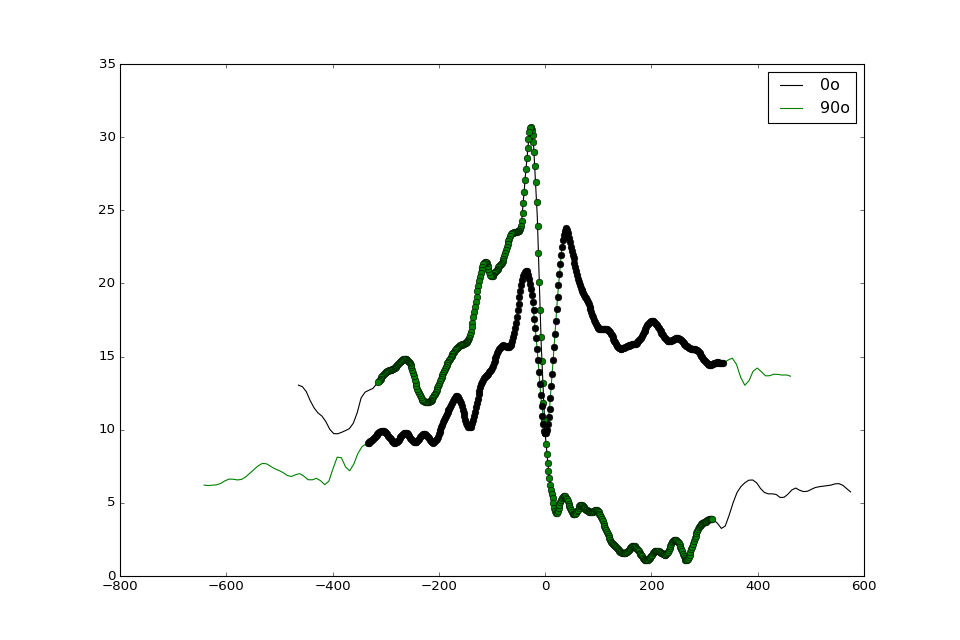

In [62]:
# print normal axis to the TC center lon,lat
plt.figure(figsize=(12,8))
plt.plot(rx,ust[lmp1,:],'k-',label='0o')
plt.plot(ry,ust[:,lmp2],'g-',label='90o')
plt.legend()

## test the interpolation  ##WORKS!!!!
plt.plot(rec[0,:],uec[0,:],'go')
plt.plot(rec[9,:],uec[9,:],'ko')
plt.plot(-rec[18,:],uec[18,:],'go')
plt.plot(-rec[27,:],uec[27,:],'ko')


plt.show()

<IPython.core.display.Javascript object>


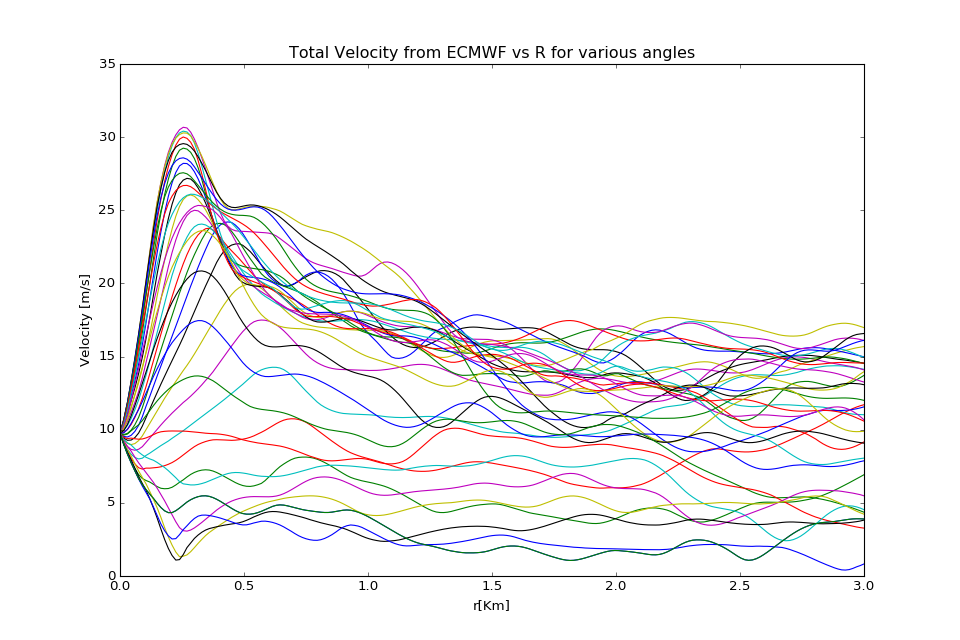

In [63]:
plt.figure(figsize=(12,8))
plt.plot(rr,uec.T)
plt.xlabel('r[Km]')
plt.ylabel('Velocity [m/s]')
plt.title('Total Velocity from ECMWF vs R for various angles')
 